# 835 Final Project

In [12]:
!wget https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py

--2024-12-05 12:57:33--  https://raw.githubusercontent.com/HobbitLong/SupContrast/refs/heads/master/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4137 (4.0K) [text/plain]
Saving to: ‘losses.py.1’

losses.py.1         100%[===================>]   4.04K  --.-KB/s    in 0s      

2024-12-05 12:57:34 (28.6 MB/s) - ‘losses.py.1’ saved [4137/4137]



In [137]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as vF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
from torchvision.models import mobilenet_v2, mobilenet_v3_large, vgg19, vgg16, resnet50, resnet18
from timm.models.swin_transformer import SwinTransformer
from sklearn.linear_model import LinearRegression
import kagglehub
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from losses import SupConLoss
from torch.nn import TripletMarginLoss
import random
from Utils import GetDataset, resnet18_model_runner_get_basic_models, PairDet

### Model
Model architecture based on TractoSCR

### Model training

In [102]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(X, dim=1)
    return X

# Hyperparameters
batch_size  = 128
epochs      = 100
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 2

sz = (126, 126)
dataset = GetDataset(data_augmentation=True, n_views=2)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr, weight_decay=1e-5)
pdr         = PairDet(threshold = 2.0)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

projs = []
temps = []
sel  = [0, 2, 4, 6, -1, -3, -5]
total_losses = []
for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = supconmodel(images).unsqueeze(1).to(device)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')
  total_losses.append(losses / count)

  supconmodel.eval()
  with torch.no_grad():
    # extract 1 batch of images and temperature
      for i, (images, temperatures) in enumerate(val_loader):
          if i == 0 or i == len(val_loader) - 1:
            N      = images.shape[0]
            V      = images.shape[1]
            images = images.reshape(N * V, 1, sz[0], sz[1])
            temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
            proj  = supconmodel(images).unsqueeze(1)
            pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
            proj  = proj.cpu().detach().numpy().squeeze()

            projs.append(proj[sel])
            temps.append(temperatures.cpu().detach().numpy().flatten()[sel])

total_losses = np.array(total_losses).squeeze()

Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

Loss: 668.80947265625
########################################
Epoch: 2
*****

Loss: 97.81805801391602
########################################
Epoch: 3
*****

Loss: 52.685950469970706
########################################
Epoch: 4
*****

Loss: 52.378117370605466
########################################
Epoch: 5
*****

Loss: 52.36625289916992
########################################
Epoch: 6
*****

Loss: 52.31260986328125
########################################
Epoch: 7
*****

Loss: 52.36292266845703
########################################
Epoch: 8
*****

Loss: 52.32780075073242
########################################
Epoch: 9
*****

Loss: 52.36113357543945
########################################
Epoch: 10
*****

Loss: 52.336219787597656
########################################
Epoch: 11
*****

Loss: 52.32624969482422
########################################
Epoch: 12
*****

Loss: 52.317422485351564
#######################

### Visualize encoding space

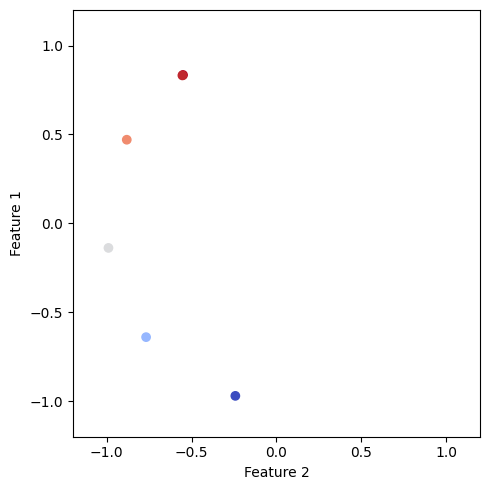

In [136]:

X = np.array(projs).reshape(len(projs)*len(sel),2)
y = np.array(temps).reshape(len(projs)*len(sel)).flatten()
alpha = np.linspace(0, 1, len(y))

plt.figure(figsize=[5, 5])
plt.scatter(X[-7:-1,0], X[-7:-1,1], c=y[-7:-1], cmap='coolwarm')
plt.xlabel("Feature 2")
plt.ylabel("Feature 1")
plt.ylim((-1.2, 1.2))
plt.xlim((-1.2, 1.2))
plt.tight_layout()
plt.show()

In [130]:
X[-7:-1,:]

array([[-0.76849407, -0.6398568 ],
       [-0.8824553 ,  0.4703963 ],
       [-0.5507383 ,  0.834678  ],
       [-0.24232757, -0.97019446],
       [-0.55453044,  0.83216345],
       [-0.9904158 , -0.13811809]], dtype=float32)

In [133]:
X[0]

array([ 0.62753755, -0.7785863 ], dtype=float32)

In [ ]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

    self.head = nn.Linear(feature_dim, 1, device=device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(X, dim=1)
    X = self.head(X)
    return X

# Hyperparameters
batch_size  = 128
epochs      = 100
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 2

sz = (126, 126)
dataset = GetDataset(data_augmentation=True, n_views=2)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr, weight_decay=1e-5)
pdr         = PairDet(threshold = 2.0)
lossfn      = torch.nn.MSELoss()

projs = []
temps = []
sel  = [0, 2, 4, 6, -1, -3, -5]
total_losses = []
for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = supconmodel(images).to(device)
    loss  = lossfn(proj, temperatures)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')
  total_losses.append(losses / count)

total_losses = np.array(total_losses).squeeze()


Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

Loss: 4529.45947265625
########################################
Epoch: 2
*****

Loss: 4732.2291015625
########################################
Epoch: 3
*****

Loss: 4651.4859375
########################################
Epoch: 4
*****

Loss: 4662.5513671875
########################################
Epoch: 5
*****

Loss: 4690.01640625
########################################
Epoch: 6
*****

Loss: 4705.40458984375
########################################
Epoch: 7
*****

Loss: 4649.391796875
########################################
Epoch: 8
*****

Loss: 4897.29072265625
########################################
Epoch: 9
*****

Loss: 4619.3869140625
########################################
Epoch: 10
*****

Loss: 4603.5244140625
########################################
Epoch: 11
*****

Loss: 4587.56396484375
########################################
Epoch: 12
*****

Loss: 4633.664501953125
########################################
Epoch: 1

In [146]:
supconmodel.eval()
with torch.no_grad():
  # extract 1 batch of images and temperature
  enc = supconmodel.encoder
  enc.eval()
  for i, (images, temperatures) in enumerate(val_loader):
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
            #proj  = supconmodel(images).unsqueeze(1)
    proj  = F.normalize(enc(images), dim=1)
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = proj.cpu().detach().numpy().squeeze()
    temperatures = temperatures.cpu().detach().numpy()

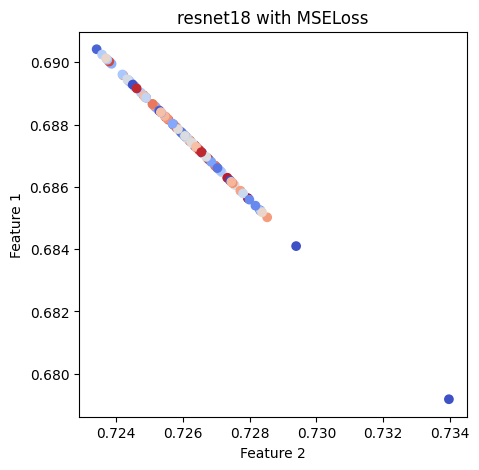

In [159]:
plt.figure(figsize=[5, 5])
plt.scatter(Xmse[:,0], Xmse[:,1], c=ymse, cmap='coolwarm')
plt.xlabel("Feature 2")
plt.ylabel("Feature 1")
plt.title("resnet18 with MSELoss")
plt.show()

In [153]:
class SupConModel(nn.Module):
  def __init__(self, feature_dim : int = 128, device : str = "cpu")->None:
    super(SupConModel, self).__init__()
    self.backbone = resnet18(pretrained=True)
    self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.backbone.fc    = nn.Identity()
    self.linear = nn.Linear(512, feature_dim)
    self.encoder = nn.Sequential(
      self.backbone,
      self.linear
    ).to(device)

    self.head = nn.Linear(feature_dim, 1, device=device)

  def forward(self, X):
    X = self.encoder(X)
    X = F.normalize(X, dim=1)
    X = self.head(X)
    return X

# Hyperparameters
batch_size  = 128
epochs      = 100
lr          = 1e-3
split_ratio = 0.9   # %
device      = "cuda:0"
features_dim = 2

sz = (126, 126)
dataset = GetDataset(data_augmentation=True, n_views=2)

# Get the total size of the dataset
dataset_size = len(dataset)

# Calculate sizes for training and validation splits
train_size = int(split_ratio * dataset_size)
val_size = dataset_size - train_size

# Perform the split
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True )
val_loader   = DataLoader(val_dataset  , batch_size=batch_size, shuffle=False)

supconmodel = SupConModel(features_dim, device)
optimizer   = torch.optim.Adam(supconmodel.parameters(), lr=lr, weight_decay=1e-5)
pdr         = PairDet(threshold = 2.0)
lossfn      = SupConLoss(base_temperature=0.001, temperature=0.01)

projs = []
temps = []
sel  = [0, 2, 4, 6, -1, -3, -5]
total_losses_sup = []
for epoch in range(epochs):
  supconmodel.train()
  print(f'########################################')
  print(f'Epoch: {epoch+1}')

  losses = 0
  count  = 0
  for images, temperatures in train_loader:
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
    ##
    ##
    ##
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = supconmodel(images).unsqueeze(1).to(device)
    loss  = lossfn(proj, mask=pairs)

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses += loss.cpu().detach().numpy()
    count  += 1
    print(f'*', end='')
  print('\n')
  print(f'Loss: {losses / count}')
  total_losses_sup.append(losses / count)

total_losses_sup = np.array(total_losses_sup).squeeze()


Path to dataset files: C:\Users\tsope\.cache\kagglehub\datasets\juanda220485\synthetic-dataset-of-speckle-images\versions\1


c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tsope\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


########################################
Epoch: 1
*****

Loss: 87.05422592163086
########################################
Epoch: 2
*****

Loss: 55.27625045776367
########################################
Epoch: 3
*****

Loss: 53.074012756347656
########################################
Epoch: 4
*****

Loss: 52.75245971679688
########################################
Epoch: 5
*****

Loss: 52.467054748535155
########################################
Epoch: 6
*****

Loss: 52.38023910522461
########################################
Epoch: 7
*****

Loss: 52.436910247802736
########################################
Epoch: 8
*****

Loss: 52.353477478027344
########################################
Epoch: 9
*****

Loss: 52.331539154052734
########################################
Epoch: 10
*****

Loss: 52.324896240234374
########################################
Epoch: 11
*****

Loss: 52.34025115966797
########################################
Epoch: 12
*****

Loss: 52.18302001953125
###################

In [154]:
supconmodel.eval()
with torch.no_grad():
  # extract 1 batch of images and temperature
  enc = supconmodel.encoder
  enc.eval()
  for i, (images, temperatures) in enumerate(val_loader):
    N      = images.shape[0]
    V      = images.shape[1]
    images = images.reshape(N * V, 1, sz[0], sz[1])
    temperatures = temperatures.unsqueeze(1).expand(-1, V).reshape(N * V, 1)
            #proj  = supconmodel(images).unsqueeze(1)
    proj  = F.normalize(enc(images), dim=1)
    pairs = pdr(temperatures).float() - torch.eye(N * V, N * V, device=device).float()
    proj  = proj.cpu().detach().numpy().squeeze()
    temperatures = temperatures.cpu().detach().numpy()

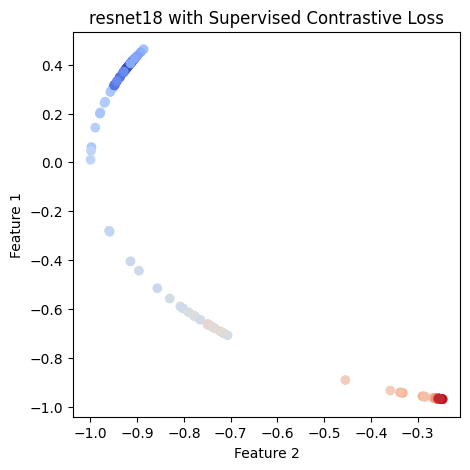

In [160]:
plt.figure(figsize=[5, 5])
plt.scatter(Xsup[:,0], Xsup[:,1], c=ysup, cmap='coolwarm')
plt.xlabel("Feature 2")
plt.ylabel("Feature 1")
plt.title("resnet18 with Supervised Contrastive Loss")
plt.show()